<h1>First try with ADAM</h1>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import os
import numpy as np
import tensorflow as tf # changed to intel-optimized build

tf.random.set_seed(42)
np.random.seed(42)

import gc
import time
import random
from winsound import Beep
from PIL import Image
import pickle
Beep(1000, 100)

In [5]:
from matplotlib import pyplot as plt

In [7]:
os.chdir(r"C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env")

<h1>load super-expanded training data</h1>

In [8]:
os.chdir(r"C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\env")
with open('useful_e_data.pkl', 'rb') as f:
    [train_x, val_x, test_x, train_y, val_y, test_y] = pickle.load(f)
    
Beep(1000, 100)

# reshape data
train_x = train_x.reshape(np.shape(train_x)[0], np.shape(train_x)[1], np.shape(train_x)[2], 1)
val_x = val_x.reshape(np.shape(val_x)[0], np.shape(val_x)[1], np.shape(val_x)[2], 1)
test_x = test_x.reshape(np.shape(test_x)[0], np.shape(test_x)[1], np.shape(test_x)[2], 1)

train_y = tf.one_hot(train_y.astype(np.int32), depth=10)
val_y = tf.one_hot(val_y.astype(np.int32), depth=10)
test_y = tf.one_hot(test_y.astype(np.int32), depth=10)
Beep(1000, 100)


<h1>sample training data<h1/>

In [13]:
# sample training data
n = len(train_x)
sn = int(n / 10)
np.random.seed(42)
index = np.random.choice([i for i in range(n)], size=sn, replace=False)

sub_tx, sub_ty = [], []

for ind in index:
    sub_tx.append(train_x[ind])
    sub_ty.append(train_y[ind])

sub_tx = np.array(sub_tx)
sub_ty = np.array(sub_ty)
sub_tx = sub_tx.reshape(np.shape(sub_tx)[0], np.shape(sub_tx)[1], np.shape(sub_tx)[2], 1)

Beep(1000, 100)

<h1>Useful functions:<h1/>

In [9]:
def plot_decay(init_val, rate, nep):
    dec_list = []
    val = init_val
    rate = rate
    for i in range(nep):
        dec_list.append(val)
        val = rate * val

    plt.plot(dec_list)
    plt.axhline(min(dec_list))
    plt.show()
    print('init eta:', init_val)
    print('min eta:', min(dec_list))
    print('#' * 50)

Beep(1000, 100)

<h1>Build Network models</h1>

<h2>SGD:<h2/>

In [10]:

def train_cnn_sgd(lmbda, batch_size, n_eph, eta, decay_steps, decay_rate, train_x, train_y, val_x, val_y, test_x, test_y):
    ################################################################
    #   relu CNN network as described in chapter 6
    ################################################################
    tf.random.set_seed(42)
    ################################################################
    print('lmbda= {}\n'.format(lmbda))
    print('eta= {}\n'.format(eta))
    print('n_eph= {}\n'.format(n_eph))
    print('batch_size= {}\n'.format(batch_size))
    print('decay_steps= {}\n'.format(decay_steps))
    print('decay_rate= {}\n'.format(decay_rate))
    ################################################################
    ################################################################
    # construct netwoek model
    input_shape = (28, 28, 1)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D( # no padding
            20,
            (5,5),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda),
            input_shape=input_shape))

    model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

    model.add(tf.keras.layers.Conv2D( # no padding
            40,
            (5,5),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

    model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(
            100,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

    model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))
    ################################################################
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=eta,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )
    ################################################################
    # compile model
    model.compile(
        optimizer=tf.keras.optimizers.SGD(
            learning_rate=lr_schedule,
            momentum=0.0,
            nesterov=False,
            name="SGD"),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    ################################################################
    model.summary()
    ################################################################
    # save the model when val_acc is best
    stamp = str(time.time()).replace('.', '_')
    print('time stamp:', stamp)
    checkpoint_filepath = r'C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\save_model\expansion\{}'.format(stamp)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    ################################################################
    ################################################################
    #    train model  
    ts = time.time()
    history = model.fit(
        train_x, train_y, 
        epochs=n_eph,
        batch_size=batch_size,
        validation_data=(val_x, val_y),
        callbacks=[model_checkpoint_callback],
        shuffle=True
    )
    te = time.time()

    print('total time:', te - ts)
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    ################################################################
    ################################################################
    #    load the weights for the best epoch (best val accuracy)
    model.load_weights(checkpoint_filepath)
    ################################################################
    ################################################################
    #    evaluate test data at the best epoch
    [test_data_loss, test_data_accuracy] = model.evaluate(
        test_x, test_y,
        batch_size=len(test_x)
    )
    ################################################################
    plt.plot(acc, label='train acc., best: {:.3f}'.format(max(acc)))
    plt.plot(val_acc, label='validation acc. best: {:.3f}'.format(max(val_acc)))
    plt.title('CNN relu, expanded train data, SGD, , eta={}, lmbda={}, {} epochs'.format(eta, lmbda, n_eph))
    plt.axvline(x=np.argmax(val_acc), c='r', ls=':', label='best epoch: {}'.format(np.argmax(val_acc)))
    plt.axhline(y=test_data_accuracy, c='r', label='test data accuracy at best epoch: {:.3f}'.format(test_data_accuracy))
    plt.legend()
    plt.show()
    Beep(1000, 100)
    print('acc', acc)
    print('loss', loss)
    print('val_acc', val_acc)
    print('val_loss', val_loss)

Beep(1000,100)


<h2>ADAM:<h2/>

In [11]:

def train_cnn_adam( # using default ADAM params
        lmbda,
        batch_size,
        n_eph,
        eta,
        train_x,
        train_y,
        val_x,
        val_y,
        test_x,
        test_y
    ):
    ################################################################
    #   relu CNN network as described in chapter 6
    ################################################################
    tf.random.set_seed(42)
    ################################################################
    print('lmbda= {}\n'.format(lmbda))
    print('n_eph= {}\n'.format(n_eph))
    print('batch_size= {}\n'.format(batch_size))
    ################################################################
    ################################################################
    # construct netwoek model
    input_shape = (28, 28, 1)
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D( # no padding
            20,
            (5,5),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda),
            input_shape=input_shape))

    model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

    model.add(tf.keras.layers.Conv2D( # no padding
            40,
            (5,5),
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

    model.add(tf.keras.layers.MaxPool2D(strides=(2,2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(
            100,
            activation=tf.nn.relu,
            kernel_regularizer=tf.keras.regularizers.L2(l2=lmbda)))

    model.add(tf.keras.layers.Dense(10,activation=tf.nn.softmax))
    ################################################################
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=eta,
        decay_steps=decay_steps,
        decay_rate=decay_rate
    )
    ################################################################
    # optimizer: SGD
    optimizer_sgd = tf.keras.optimizers.SGD(
        learning_rate=lr_schedule,
        momentum=0.0,
        nesterov=False,
        name="SGD"
    )
    ################################################################
    # optimizer: ADAM
    optimizer_adam = tf.keras.optimizers.Adam(
        learning_rate=0.001,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-07,
        amsgrad=False,
        name='Adam'
    )
    ################################################################
    # compile model
    model.compile(
        optimizer=optimizer_adam,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    ################################################################
    model.summary()
    ################################################################
    # save the model when val_acc is best
    stamp = str(time.time()).replace('.', '_')
    print('time stamp:', stamp)
    checkpoint_filepath = r'C:\Users\mchen\OneDrive\桌面\ml\code\tutorial\chapter6\save_model\expansion\{}'.format(stamp)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True)
    ################################################################
    ################################################################
    #    train model  
    ts = time.time()
    history = model.fit(
        train_x, train_y, 
        epochs=n_eph,
        batch_size=batch_size,
        validation_data=(val_x, val_y),
        callbacks=[model_checkpoint_callback],
        shuffle=True
    )
    te = time.time()

    print('total time:', te - ts)
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    ################################################################
    ################################################################
    #    load the weights for the best epoch (best val accuracy)
    model.load_weights(checkpoint_filepath)
    ################################################################
    ################################################################
    #    evaluate test data at the best epoch
    [test_data_loss, test_data_accuracy] = model.evaluate(
        test_x, test_y,
        batch_size=len(test_x)
    )
    ################################################################
    plt.plot(acc, label='train acc., best: {:.3f}'.format(max(acc)))
    plt.plot(val_acc, label='validation acc. best: {:.3f}'.format(max(val_acc)))
    plt.title('CNN relu, expanded train data, ADAM, , eta={}, lmbda={}, {} epochs'.format(eta, lmbda, n_eph))
    plt.axvline(x=np.argmax(val_acc), c='r', ls=':', label='best epoch: {}'.format(np.argmax(val_acc)))
    plt.axhline(y=test_data_accuracy, c='r', label='test data accuracy at best epoch: {:.3f}'.format(test_data_accuracy))
    plt.legend()
    plt.show()
    Beep(1000, 100)
    print('acc', acc)
    print('loss', loss)
    print('val_acc', val_acc)
    print('val_loss', val_loss)

Beep(1000,100)


<h1>SGD vs ADAM<h1/>

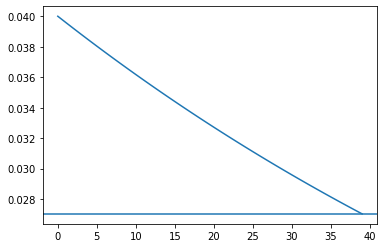

init eta: 0.04
min eta: 0.027029161962411334
##################################################
lmbda= 0.0001

eta= 0.04

n_eph= 40

batch_size= 7500

decay_steps= 100

decay_rate= 0.99

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 40)          20040     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 4, 4, 40)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 640)               0         
_________________________________________________________________

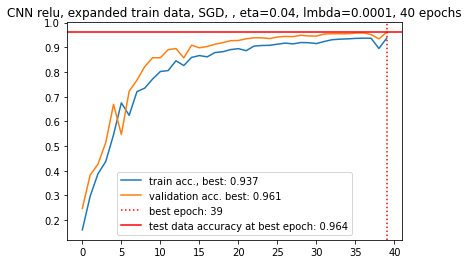

acc [0.16035999357700348, 0.29660001397132874, 0.38734665513038635, 0.4374133348464966, 0.5458666682243347, 0.6749733090400696, 0.6244933605194092, 0.7204933166503906, 0.73471999168396, 0.7712533473968506, 0.801853358745575, 0.805786669254303, 0.8453599810600281, 0.8260666728019714, 0.8591200113296509, 0.8663866519927979, 0.8612533211708069, 0.8786666393280029, 0.881986677646637, 0.8906800150871277, 0.8943333625793457, 0.8863333463668823, 0.9047866463661194, 0.9072800278663635, 0.9079333543777466, 0.9125866889953613, 0.9169466495513916, 0.9137866497039795, 0.9192399978637695, 0.9185199737548828, 0.9150800108909607, 0.9234799742698669, 0.9305999875068665, 0.9328933358192444, 0.934053361415863, 0.9359599947929382, 0.9368000030517578, 0.9367466568946838, 0.8950133323669434, 0.936959981918335]
loss [2.3326990604400635, 2.290973663330078, 2.236682176589966, 2.122762441635132, 1.8521597385406494, 1.3847630023956299, 1.2682675123214722, 0.92950439453125, 0.8453489542007446, 0.710019052028656,

23961

In [16]:
lmbda = 0.1 / 10 / 10 / 10
batch_size = 7500
n_eph = 40

eta = 0.04
decay_steps = int(len(train_x) / batch_size) # 1 decay per epoch
decay_rate = 0.99
plot_decay(eta, decay_rate, n_eph)
    
a = train_cnn_sgd(
    lmbda,
    batch_size,
    n_eph, eta,
    decay_steps,
    decay_rate,
    sub_tx,
    sub_ty,
    val_x,
    val_y,
    test_x,
    test_y
)

del a
gc.collect()



lmbda= 0.0001

n_eph= 40

batch_size= 7500

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 24, 24, 20)        520       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 20)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 40)          20040     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 4, 40)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 640)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               64100     
_________________________________________________________________
dense_7 (D

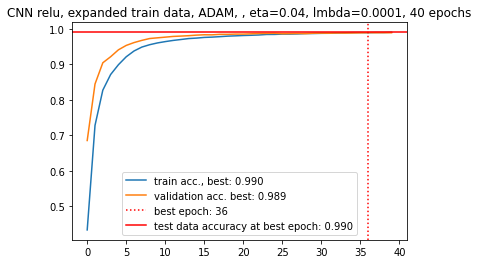

acc [0.4333600103855133, 0.7278133630752563, 0.8270666599273682, 0.8710933327674866, 0.8987200260162354, 0.9211199879646301, 0.9374266862869263, 0.9484266638755798, 0.955079972743988, 0.9600933194160461, 0.9638400077819824, 0.9671199917793274, 0.9697333574295044, 0.9724266529083252, 0.9737066626548767, 0.975653350353241, 0.9764666557312012, 0.9778000116348267, 0.9792266488075256, 0.9800666570663452, 0.9810400009155273, 0.9816799759864807, 0.9825066924095154, 0.9839733242988586, 0.9840800166130066, 0.9849466681480408, 0.985040009021759, 0.9855466485023499, 0.9865466952323914, 0.9866666793823242, 0.987173318862915, 0.987333357334137, 0.9881066679954529, 0.9886800050735474, 0.9891600012779236, 0.989359974861145, 0.9889199733734131, 0.9895200133323669, 0.9893733263015747, 0.9902133345603943]
loss [2.147562026977539, 1.2369688749313354, 0.590867817401886, 0.448016881942749, 0.35809558629989624, 0.28668278455734253, 0.23611539602279663, 0.200322687625885, 0.17494438588619232, 0.1566761136054

14824

In [17]:
lmbda = 0.1 / 10 / 10 / 10
batch_size = 7500
n_eph = 40

    
a = train_cnn_adam( # using default ADAM params
    lmbda,
    batch_size,
    n_eph,
    eta,
    sub_tx,
    sub_ty,
    val_x,
    val_y,
    test_x,
    test_y
)

del a
gc.collect()



<h1><h1/>

<h1>SGD result, 96.4%, 401s<h1/>

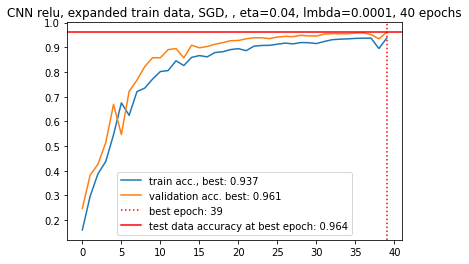

<h1>ADAM result, 99.0%, 410s<h1/>

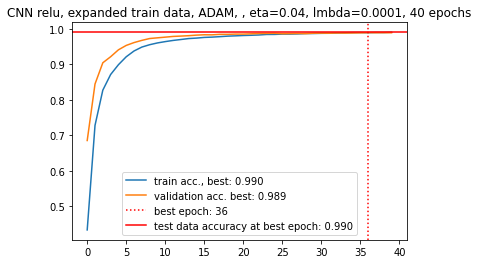

<h1>ADAM is so much better!!!!!!!!!!!!!<h1/>